# **AI-Based E-Waste Identification Using Camera Input**

Module: M516 – Business Project in Big Data & AI  
Student Name: Dinakar Vennalakanti
Date: 18th December 2025

## **Notebook 01: Problem and Data Understanding**

## Background and Motivation

Electronic waste, commonly known as e-waste, represents one of the fastest growing waste streams globally. Items such as batteries, circuit boards, mobile phones, and chargers are frequently discarded despite containing valuable and hazardous materials.

Recycling centres often rely on manual sorting processes, which are labour-intensive, time-consuming, and prone to error. The lack of automated identification systems limits the efficiency of recycling operations and contributes to low recovery rates.

Advances in computer vision and deep learning provide an opportunity to automatically identify e-waste items using visual input. This project explores whether a locally deployed AI system can classify e-waste items using camera input as a proof-of-concept for sustainability-focused decision support.


## Problem Statement

Recycling facilities lack accessible AI-based tools that can automatically identify types of electronic waste using camera input.

This limitation reduces the ability to:
- Understand e-waste composition
- Improve sorting efficiency
- Support sustainable recycling decisions

This project investigates the feasibility of using image classification techniques to identify e-waste items from camera input in a local environment.


## Project Objectives

The objectives of this project are:

1. To analyse and understand publicly available e-waste image datasets.
2. To perform exploratory data analysis to assess dataset quality and structure.
3. To train and evaluate an image classification model for e-waste identification.
4. To deploy the trained model locally and demonstrate real-time classification using a webcam.
5. To critically evaluate the limitations and sustainability implications of the approach.


## Scope and Assumptions

The project operates under the following assumptions:

- Only one primary object is visible in the camera frame at a time.
- The object is placed close to the camera and reasonably well-lit.
- The task is image classification, not object detection.
- Model inference is performed entirely on a local machine.
- Cloud deployment and industrial-scale integration are outside the scope.

The system is designed as a proof-of-concept rather than a production-ready solution.

## Dataset Overview

### Kaggle E-Waste Image Dataset

Source:
https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset

This dataset contains labelled images of common electronic waste categories and is used as the primary dataset for model training and validation.

### Roboflow E-Waste Dataset

Source:
https://universe.roboflow.com/electronic-waste-detection/e-waste-dataset-r0ojc

This dataset is used only for qualitative evaluation and webcam inference testing. It is not used during training to avoid data leakage and annotation inconsistencies.


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dinakarvennalakanti","key":"c12083da38a8fc8817f3a2ca9b080390"}'}

In [3]:
import os
os.makedirs("/root/.kaggle", exist_ok=True)

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls -la /root/.kaggle


total 16
drwxr-xr-x 2 root root 4096 Dec 18 01:14 .
drwx------ 1 root root 4096 Dec 18 01:14 ..
-rw------- 1 root root   75 Dec 18 01:14 kaggle.json


In [4]:
os.makedirs("/content/data", exist_ok=True)

!kaggle datasets download -d akshat103/e-waste-image-dataset -p /content/data


Dataset URL: https://www.kaggle.com/datasets/akshat103/e-waste-image-dataset
License(s): apache-2.0
  0% 0.00/11.8M [00:00<?, ?B/s]
100% 11.8M/11.8M [00:00<00:00, 1.09GB/s]


In [5]:
import zipfile

zip_path = "/content/data/e-waste-image-dataset.zip"
extract_path = "/content/data/e_waste"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Verify extraction
!ls /content/data/e_waste


modified-dataset


In [6]:
BASE_DATA_PATH = "/content/data/e_waste/modified-dataset"

TRAIN_PATH = f"{BASE_DATA_PATH}/train"
VAL_PATH   = f"{BASE_DATA_PATH}/val"
TEST_PATH  = f"{BASE_DATA_PATH}/test"

print("Base dataset path:", BASE_DATA_PATH)


Base dataset path: /content/data/e_waste/modified-dataset


In [7]:
import os

for split_name, split_path in {
    "TRAIN": TRAIN_PATH,
    "VALIDATION": VAL_PATH,
    "TEST": TEST_PATH
}.items():

    assert os.path.exists(split_path), f"{split_name} path not found"

    classes = [
        d for d in os.listdir(split_path)
        if os.path.isdir(os.path.join(split_path, d))
    ]

    print(f"\n{split_name} SET")
    print("Number of classes:", len(classes))
    for cls in sorted(classes):
        print("-", cls)



TRAIN SET
Number of classes: 10
- Battery
- Keyboard
- Microwave
- Mobile
- Mouse
- PCB
- Player
- Printer
- Television
- Washing Machine

VALIDATION SET
Number of classes: 10
- Battery
- Keyboard
- Microwave
- Mobile
- Mouse
- PCB
- Player
- Printer
- Television
- Washing Machine

TEST SET
Number of classes: 10
- Battery
- Keyboard
- Microwave
- Mobile
- Mouse
- PCB
- Player
- Printer
- Television
- Washing Machine


In [1]:
!pip install kaggle tensorflow pillow matplotlib seaborn scikit-learn

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set(style="whitegrid")


In [9]:
def count_images(path):
    return {
        cls: len(os.listdir(os.path.join(path, cls)))
        for cls in os.listdir(path)
    }

df_counts = pd.DataFrame({
    "Train": count_images(TRAIN_PATH),
    "Validation": count_images(VAL_PATH),
    "Test": count_images(TEST_PATH)
})

df_counts


,Train,Validation,Test
PCB,240,30,30
Washing Machine,240,30,30
Battery,240,30,30
Keyboard,240,30,30
Mobile,240,30,30
Television,240,30,30
Player,240,30,30
Printer,240,30,30
Mouse,240,30,30
Microwave,240,30,30


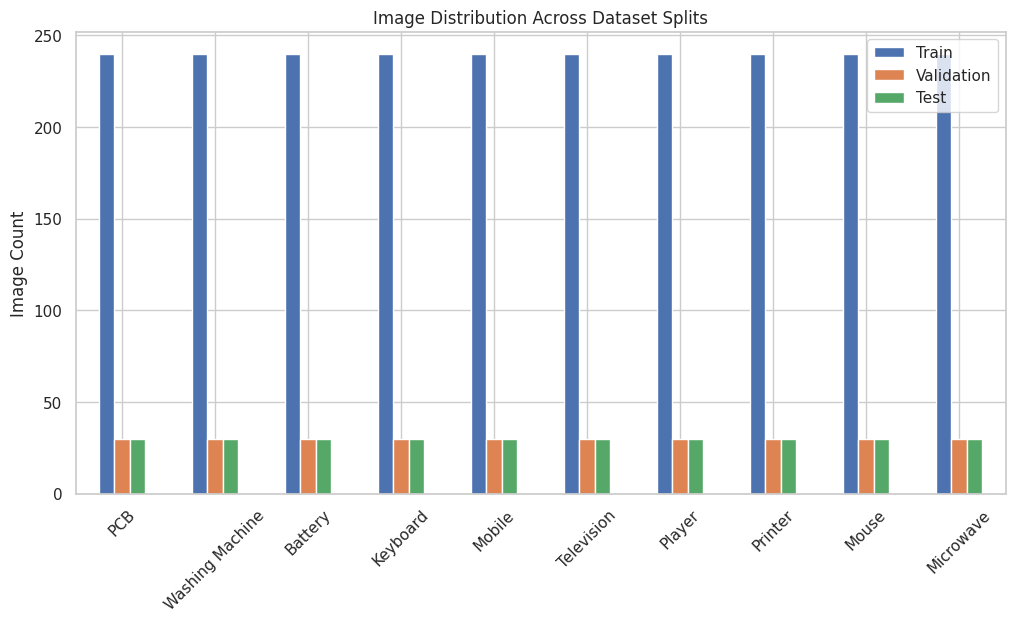

In [11]:
df_counts.plot(kind="bar", figsize=(12,6))
plt.title("Image Distribution Across Dataset Splits")
plt.ylabel("Image Count")
plt.xticks(rotation=45)
plt.show()


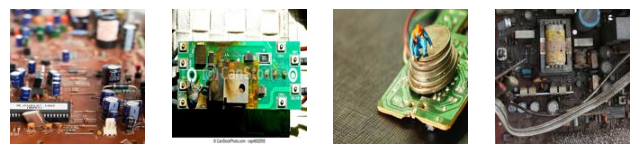

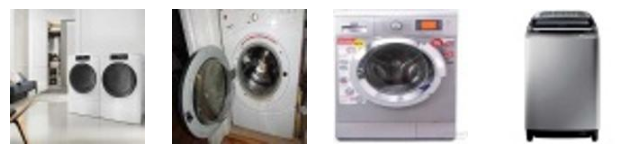

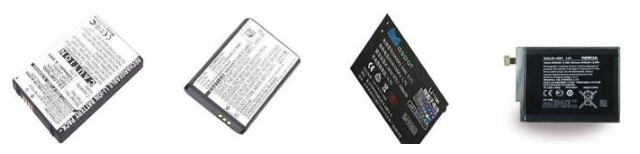

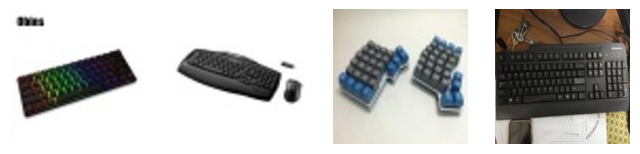

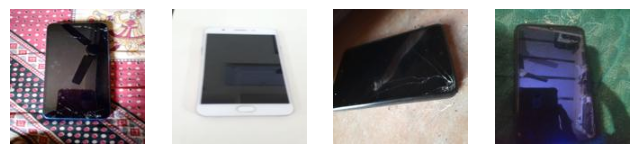

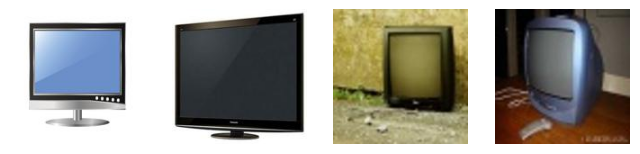

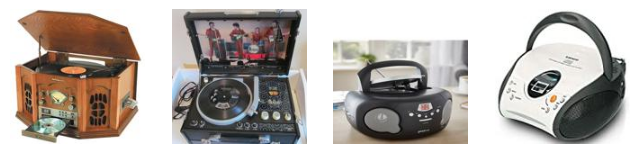

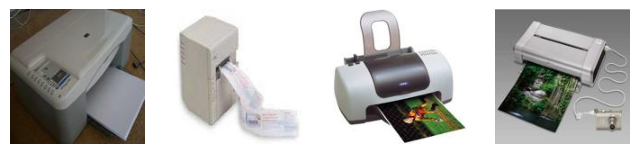

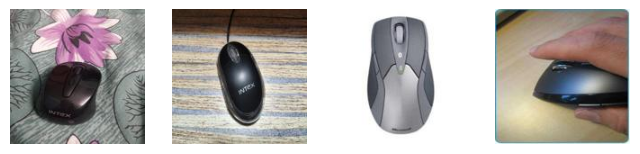

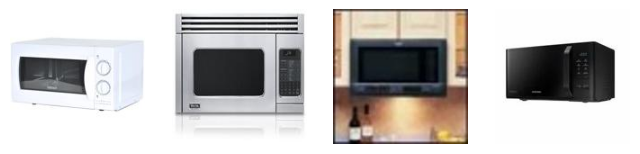

In [12]:
def show_samples(class_name, n=4):
    imgs = os.listdir(os.path.join(TRAIN_PATH, class_name))[:n]
    plt.figure(figsize=(n*2,2))
    for i, img in enumerate(imgs):
        im = Image.open(os.path.join(TRAIN_PATH, class_name, img))
        plt.subplot(1,n,i+1)
        plt.imshow(im)
        plt.axis("off")
    plt.show()

for cls in os.listdir(TRAIN_PATH):
    show_samples(cls)


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [14]:
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.1,
    horizontal_flip=True
)

val_test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_data = val_test_gen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_data = val_test_gen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 2400 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 300 images belonging to 10 classes.


In [15]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation="relu"),
    Dense(train_data.num_classes, activation="softmax")
])

model.compile(
    optimizer=Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,242 (9.24 MB)

 Trainable params: 165,258 (645.54 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.3205 - loss: 2.0112 - val_accuracy: 0.8267 - val_loss: 0.9513
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.7959 - loss: 0.8484 - val_accuracy: 0.8833 - val_loss: 0.4706
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.8730 - loss: 0.4859 - val_accuracy: 0.9033 - val_loss: 0.3345
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.8982 - loss: 0.3747 - val_accuracy: 0.9267 - val_loss: 0.2755
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9160 - loss: 0.3072 - val_accuracy: 0.9367 - val_loss: 0.2363
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9302 - loss: 0.2570 - val_accuracy: 0.9433 - val_loss: 0.2149
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.9318 - loss: 0.2463 - val_accuracy: 0.9433 - val_loss: 0.2002
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9447 - loss: 0.2157 - val_accuracy: 0.9467 - v

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes
labels = list(test_data.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=labels))


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step
                 precision    recall  f1-score   support

        Battery       0.86      0.80      0.83        30
       Keyboard       1.00      0.97      0.98        30
      Microwave       0.94      0.97      0.95        30
         Mobile       0.96      0.90      0.93        30
          Mouse       0.93      0.90      0.92        30
            PCB       0.97      0.97      0.97        30
         Player       0.88      0.97      0.92        30
        Printer       0.94      0.97      0.95        30
     Television       0.87      0.90      0.89        30
Washing Machine       0.97      0.97      0.97        30

       accuracy                           0.93       300
      macro avg       0.93      0.93      0.93       300
   weighted avg       0.93      0.93      0.93       300



In [19]:
model.class_names = list(train_data.class_indices.keys())

model.save("/content/ewaste_classifier.h5")
print("Model saved.")

Model saved.
